In [51]:

%matplotlib inline
#import wget
#import xarray
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import pydap
from datetime import date, timedelta
from pydap.client import open_url
from pydap.cas.urs import setup_session

## Soil moisture/root water/ rainfall Data

In [ ]:
dataset_url = 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/hyrax/GLDAS/GLDAS_NOAH025_M.2.1/2017/GLDAS_NOAH025_M.A201701.021.nc4'
session = setup_session(<user>, <pass>, check_url=dataset_url)
dataset = open_url(dataset_url, session=session)
#url='ftp://podaac-ftp.jpl.nasa.gov/allData/tellus/L3/gldas_monthly/netcdf/GLDAS_NOAH10_M.A200101_201501.totalH2O.nc'
#name = url.split("/")[-1]
#wget.download(url)

In [2]:
def dataConnection(url): 
    session = setup_session(<user>, <pass>, check_url=url)
    filename = open_url(url, session=session)
    print('Data connected')
    return filename

In [7]:
def earthdata2tif(dataset,variable,outFile):
    metadata = dataset.attributes['HDF5_GLOBAL']
    Wdata = dataset[variable][0][:][:]
    # Return basic info to be used in the profile
    rows, columns = Wdata[0].shape
    flipped_array = np.flipud(Wdata[0])
    # Return lat - lon info
    north = metadata['SOUTH_WEST_CORNER_LAT'] + (rows * metadata['DY'])
    west = metadata['SOUTH_WEST_CORNER_LON']
    # Transformation function
    trans = rasterio.transform.from_origin(west, north, metadata['DX'], metadata['DY'])
    # Profile
    profile = {'driver': 'GTiff', 
           'dtype': 'float64',
           'compress': 'lzw',
           'nodata': metadata['missing_value'],
           'width': columns,
           'height': rows,
           'count': 1,
           'crs':'EPSG:4326',
           'transform': trans,
           'tiled': False}
    # tif creation
    with rasterio.open(outFile, 'w', **profile) as dst:
        dst.write(flipped_array.astype(profile['dtype']), 1)
    print('transformation finish')

In [ ]:
# S3 upload
def s3Upload(outFile):
    conn = tinys3.Connection(os.getenv('S3_ACCESS_KEY'),os.getenv('S3_SECRET_KEY'), tls=True, default_bucket=os.getenv('BUCKET'), endpoint="s3.amazonaws.com")
    # So we could skip the bucket parameter on every request
    response = conn.upload(key=outFile, local_file=open(outFile,'rb'), public=True, close=True)
    if response.status_code==200:
        print('SUCCESS')
    else:
        print('UPLOAD PROCESS FAILURE STATUS CODE:' + str(response.status_code))
        print(response.content)


In [64]:
# Execution
def main():
    #variables
    outFile ={'SoilMoi0_10cm_inst':'landWaterContent.tif',
              'SoilTMP0_10m_inst':'SoilWaterContent.tif',
              'Rainff_tavg':'Rainfall.tif'}
    # start point
    today = date.today()
    lastDate = today - timedelta(days=(today.day))
    url = 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/hyrax/GLDAS/GLDAS_NOAH025_M.2.1/'+ lastDate.strftime("%Y") +'/GLDAS_NOAH025_M.A' + lastDate.strftime("%Y%m") + '.021.nc4' 
    print(url)
    try:
        file = dataConnection(url)
        dataKeys = list(set(file.keys()).intersection(outFile.keys()))
        if len(dataKeys)!=0:
            if len(dataKeys)<len(outFile.keys()):
                print(list(set(outFile.keys()).difference(dataKeys)))
            for indicator in dataKeys:
                earthdata2tif(file,indicator,outFile[indicator])
                s3Upload(outFile[indicator])
        else:
            print('beee')
    except IOError:
        print('cannot open')
    

In [65]:
main()


https://hydro1.gesdisc.eosdis.nasa.gov/opendap/hyrax/GLDAS/GLDAS_NOAH025_M.2.1/2017/GLDAS_NOAH025_M.A201704.021.nc4
Data connected
['Rainff_tavg', 'SoilTMP0_10m_inst']
transformation finish


[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]


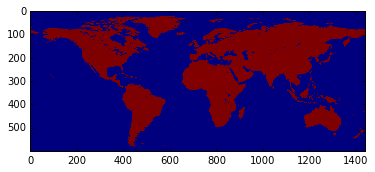

In [10]:
Wdata = file.SoilMoi0_10cm_inst[0][:][:]
print(Wdata[0])
plt.imshow(np.flipud(Wdata[0]))

In [29]:
outFile ={'SoilMoi0_10cm_ins':'landWaterContent.tif',
              'SoilTMP0_10m_inst':'landWaterContent.tif',
              'Rainff_tavg':'landWaterContent.tif'}
outFile.keys()

#c = list(set(a).intersection(b))



dict_keys(['SoilMoi0_10cm_ins', 'Rainff_tavg', 'SoilTMP0_10m_inst'])